In [1]:
import numpy as np
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from string import punctuation
from gensim import corpora, models
import networkx as nx
import matplotlib.pyplot as plt
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW, get_scheduler
import torch
from torch.utils.data import Dataset, DataLoader



In [2]:
# Load the English language model
nlp = spacy.load("en_core_web_lg")

# Load data
df = pd.read_csv("./Text_Summarization/train.csv", encoding='latin-1')

# Split the dataset into training and validation sets (80-20 split)
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

# Print the sizes of the training and validation sets
print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {validation_df.shape}")

# Save the validation set to a new CSV file if needed
validation_df.to_csv("./Text_Summarization/BigBangTheory_validation.csv", index=False)

# Use the validation dataset for testing
validation_texts = validation_df["document"].tolist()

text_corpus = train_df["document"].tolist()
summary_corpus = train_df["summary"].tolist()

# Custom stop words
custom_stop_words = {"$", "£", "€"}
tokenizer = Tokenizer(nlp.vocab)

Training set size: (16000, 2)
Validation set size: (4000, 2)


In [3]:
# Preprocess and annotate the text corpus
def preprocess_and_annotate(corpus):
    annotated_corpus = []
    for text in corpus:
        doc = tokenizer(text)
        tokens = []
        pos_tags = []
        for token in doc:
            if token.text.lower() not in STOP_WORDS.union(custom_stop_words) and token.text not in punctuation:
                tokens.append((token.text, token.lemma_))
                pos_tags.append((token.text, token.pos_))
        entities = [(ent.text, ent.label_) for ent in nlp(text).ents]
        word_embeddings = np.array([token.vector for token in doc if not token.is_stop])
        annotated_corpus.append({
            'text': text,
            'tokens': tokens,
            'pos_tags': pos_tags,
            'entities': entities,
            'word_embeddings': word_embeddings
        })
    return annotated_corpus

In [4]:
annotated_corpus = preprocess_and_annotate(text_corpus)

In [5]:
# Preprocess and extract tokens
text_filtered = []
for annotation in annotated_corpus:
    preprocessed_corpus = [token[0] for token in annotation['tokens']]
    text_filtered.append(preprocessed_corpus)

In [6]:
# Topic Modeling with LDA
dictionary = corpora.Dictionary(text_filtered)
corpus = [dictionary.doc2bow(text) for text in text_filtered]
lda_model = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5)

In [7]:
# Visualization of LDA topics
def plot_lda_topics(lda_model, dictionary, num_words=10):
    topics = lda_model.show_topics(formatted=False)
    for topic_num, topic in topics:
        words, weights = zip(*topic)
        plt.figure()
        plt.barh(words, weights)
        plt.title(f"Topic {topic_num}")
        plt.xlabel('Weights')
        plt.ylabel('Words')
        plt.show()

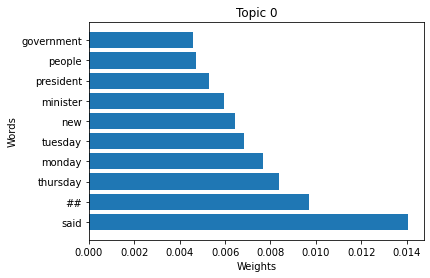

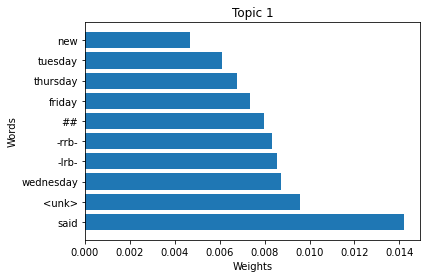

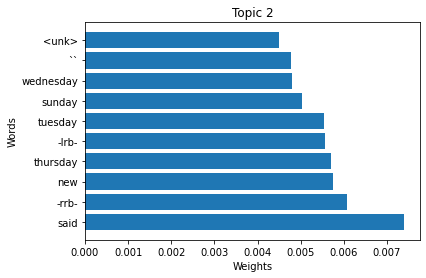

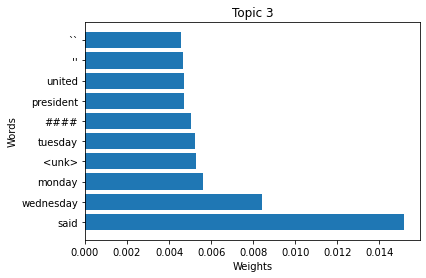

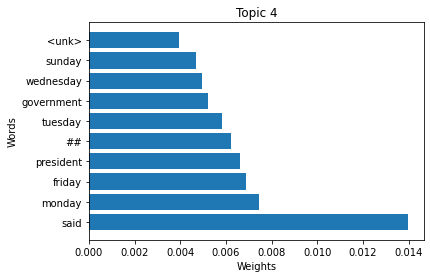

In [8]:
plot_lda_topics(lda_model, dictionary)

In [9]:
# Abstractive Summarization with T5
#model_type = "t5-large"
model_type = "t5-base"
model_max_length = 512

model = T5ForConditionalGeneration.from_pretrained(model_type)
tokenizer = T5Tokenizer.from_pretrained(model_type, model_max_length=model_max_length)

C:\Users\revan\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\serialization.py:871: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  obj = cast(Storage, torch._UntypedStorage(nbytes))


In [10]:
# Custom dataset for training
class TextSummaryDataset(Dataset):
    def __init__(self, documents, summaries, tokenizer, max_length=512):
        self.documents = documents
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, idx):
        document = self.documents[idx]
        summary = self.summaries[idx]
        inputs = self.tokenizer("summarize: " + document, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)
        with self.tokenizer.as_target_tokenizer():
            labels = self.tokenizer(summary, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)
        return {"input_ids": inputs["input_ids"].squeeze(), "attention_mask": inputs["attention_mask"].squeeze(), "labels": labels["input_ids"].squeeze()}

In [11]:
# Create dataloaders
train_dataset = TextSummaryDataset(train_df["document"].tolist(), train_df["summary"].tolist(), tokenizer)
validation_dataset = TextSummaryDataset(validation_df["document"].tolist(), validation_df["summary"].tolist(), tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False)

In [ ]:
# Training loop
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1}/{num_epochs} completed.")

C:\Users\revan\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Evaluation
def evaluate_model(model, tokenizer, dataloader, device):
    model.eval()
    predictions, references = [], []
    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)
            outputs = model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=150)
            predictions.extend([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in outputs])
            references.extend([tokenizer.decode(l, skip_special_tokens=True, clean_up_tokenization_spaces=False) for l in labels])
    return predictions, references

In [ ]:
validation_predictions, validation_references = evaluate_model(model, tokenizer, validation_dataloader, device)

In [ ]:
# Calculate Precision, Recall, and F1-Score
def calculate_scores(predictions, references):
    precisions, recalls, f1s = [], [], []
    for pred, ref in zip(predictions, references):
        pred_tokens = set(pred.split())
        ref_tokens = set(ref.split())
        common_tokens = pred_tokens.intersection(ref_tokens)
        if len(pred_tokens) > 0:
            precision = len(common_tokens) / len(pred_tokens)
            recall = len(common_tokens) / len(ref_tokens)
            f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1s)
    return avg_precision, avg_recall, avg_f1

In [ ]:
precision, recall, f1 = calculate_scores(validation_predictions, validation_references)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

In [ ]:
# Save the model
model.save_pretrained("./Text_Summarization/t5_finetuned")
tokenizer.save_pretrained("./Text_Summarization/t5_finetuned")